In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
font = {"family": "Noto Sans", "weight": "normal", "size": 12}
plt.rc("font", **font)

# Load Data

In [2]:
path = "input/Online Retail.xlsx"
df = pd.read_excel(path)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Preprocess Data

In [8]:
def preprocess_df(df):
    return (df
        .dropna(subset="CustomerID")
        .dropna(subset="InvoiceDate")
        .assign(
            customer_id = lambda df_: df_["CustomerID"].astype(int), 
            transaction_date = lambda df_: pd.to_datetime(df_["InvoiceDate"]), 
        )
        .loc[
            lambda df_: df_["transaction_date"] < "1 Dec 2011", 
            ["transaction_date", "customer_id"]
        ]
        .dropna(how="any")
        .reset_index(drop=True)
    )

df_clean = preprocess_df(df)

# Cohort Analysis

In [33]:
def fillna_diagonal_lower_right(df: pd.DataFrame) -> pd.DataFrame:
    """Change the value of bottom right diagonal with nan.

    Args:
        df (pd.DataFrame): DF with shape a*a.

    Returns:
        pd.DataFrame: DF with bottom right diagonal nan.
    """

    df = df.astype(float)

    # # set the diagonal elements to NaN
    # np.fill_diagonal(np.fliplr(df.values), np.nan)
    # get the lower right quadrant
    rows, cols = np.tril_indices(len(df), k=-1)
    reversed_cols = len(df) - 1 - cols  
    df.values[rows, reversed_cols] = np.nan
    return df


def check_cohort(raw_df: pd.DataFrame, cohort_df: pd.DataFrame) -> bool:
    """Check the result of funcion make_cohort with manual calculation
    for the first three months.

    Args:
        raw_df (pd.DataFrame): Input DF to make_cohort with two columns; ["transaction_date", "customer_id"].
        cohort_df (pd.DataFrame): Resulting DF of make_cohort.

    Returns:
        bool: True if the resulting DF of make_cohort correspond with manual calculation.
    """

    first_trans = raw_df["transaction_date"].min()
    first_month = first_trans - pd.offsets.MonthBegin(-1) # month after the first trans
    second_month = first_trans - pd.offsets.MonthBegin(-2)
    third_month = first_trans - pd.offsets.MonthBegin(-3)

    # all customer in month 0
    month_zero_cust = raw_df.loc[
        (raw_df["transaction_date"].dt.month == first_trans.month) & (raw_df["transaction_date"].dt.year == first_trans.year), 
        "customer_id"
    ].unique()

    result = []
    # get all customer of month 0 who buy again in month 1, 2 and 3
    # return the percentage of each relative to number of customer in month 0
    for m in [first_month, second_month, third_month]:
        month_cust = raw_df.loc[
            (raw_df["transaction_date"].dt.month == m.month) & (raw_df["transaction_date"].dt.year == m.year) &
            (raw_df["customer_id"].isin(month_zero_cust)), 
            "customer_id"
        ].unique()
        result.append(len(month_cust)/len(month_zero_cust))

    return (cohort_df.iloc[0, [1, 2, 3]].to_list() == result)


def make_cohort(df: pd.DataFrame) -> pd.DataFrame:
    """Do a cohort analysis.

    Args:
        df (pd.DataFrame): A DF with two columns; ["transaction_date", "customer_id"].

    Returns:
        pd.DataFrame: A pivoted DF with cohort.
    """

    df_result = (df
        .sort_values(["transaction_date", "customer_id"])
        .assign(
            # customer first purchase
            first_purchase = lambda df_: (df_
                                        .groupby(["customer_id"])["transaction_date"]
                                        .transform("min") + 
                                        pd.offsets.MonthEnd(0) - 
                                        pd.offsets.MonthBegin(1)
                                        ).dt.date,
            # distance betweeen first purchase and transaction date (in month)
            months_after_first_transaction = lambda df_: (
                # convert transaction date to first day of the month
                (df_["transaction_date"] + pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)).dt.to_period("M")
                - pd.to_datetime(df_["first_purchase"]).dt.to_period("M")
            ).apply(lambda x: x.n) # cast to int 
        )
        .groupby(["first_purchase", "months_after_first_transaction"])
        .agg(
            num_cust = ("customer_id", "nunique")
        )
        # get the initial number of customer/customer in month 0 for denominator
        .assign(
            num_cust_first_month = lambda df_: np.where(
                df_.index.get_level_values("months_after_first_transaction") == 0, 
                df_["num_cust"], np.nan
            )
        )
        .assign(
            # ffill to get the denominator
            num_cust_first_month = lambda df_: df_["num_cust_first_month"].ffill(),
            # get the percentage of each month relative to month 0
            percentage_to_num_cust_first_month = lambda df_: df_["num_cust"] / df_["num_cust_first_month"]
        )
        # pivot
        .reset_index()
        .pivot(
            index = "first_purchase",
            columns = "months_after_first_transaction", 
            values = "percentage_to_num_cust_first_month"
        )
        # fillna in case if there is month without buyer
        # however, this will fill the lower right diagonal with 0
        .fillna(0)
        # fill diagonal with na again
        .pipe(fillna_diagonal_lower_right)
        # rename axis
        .rename_axis("Months after First Transaction", axis=1)
        .rename_axis("First Transaction", axis=0)
    )
    # format the index
    df_result.index = pd.to_datetime(df_result.index).strftime('%b %Y')

    # get average per months after transaction
    df_result = (df_result
        .transpose()
        .assign(Average=lambda df_: df_.mean(axis=1))
        .transpose()
    )

    # check if cohort calculation is correct then return 
    if check_cohort(df, df_result):
        return df_result
    else:
        raise Exception("check_cohort failed.")

In [37]:
df_cohort = make_cohort(df_clean)

# Plot

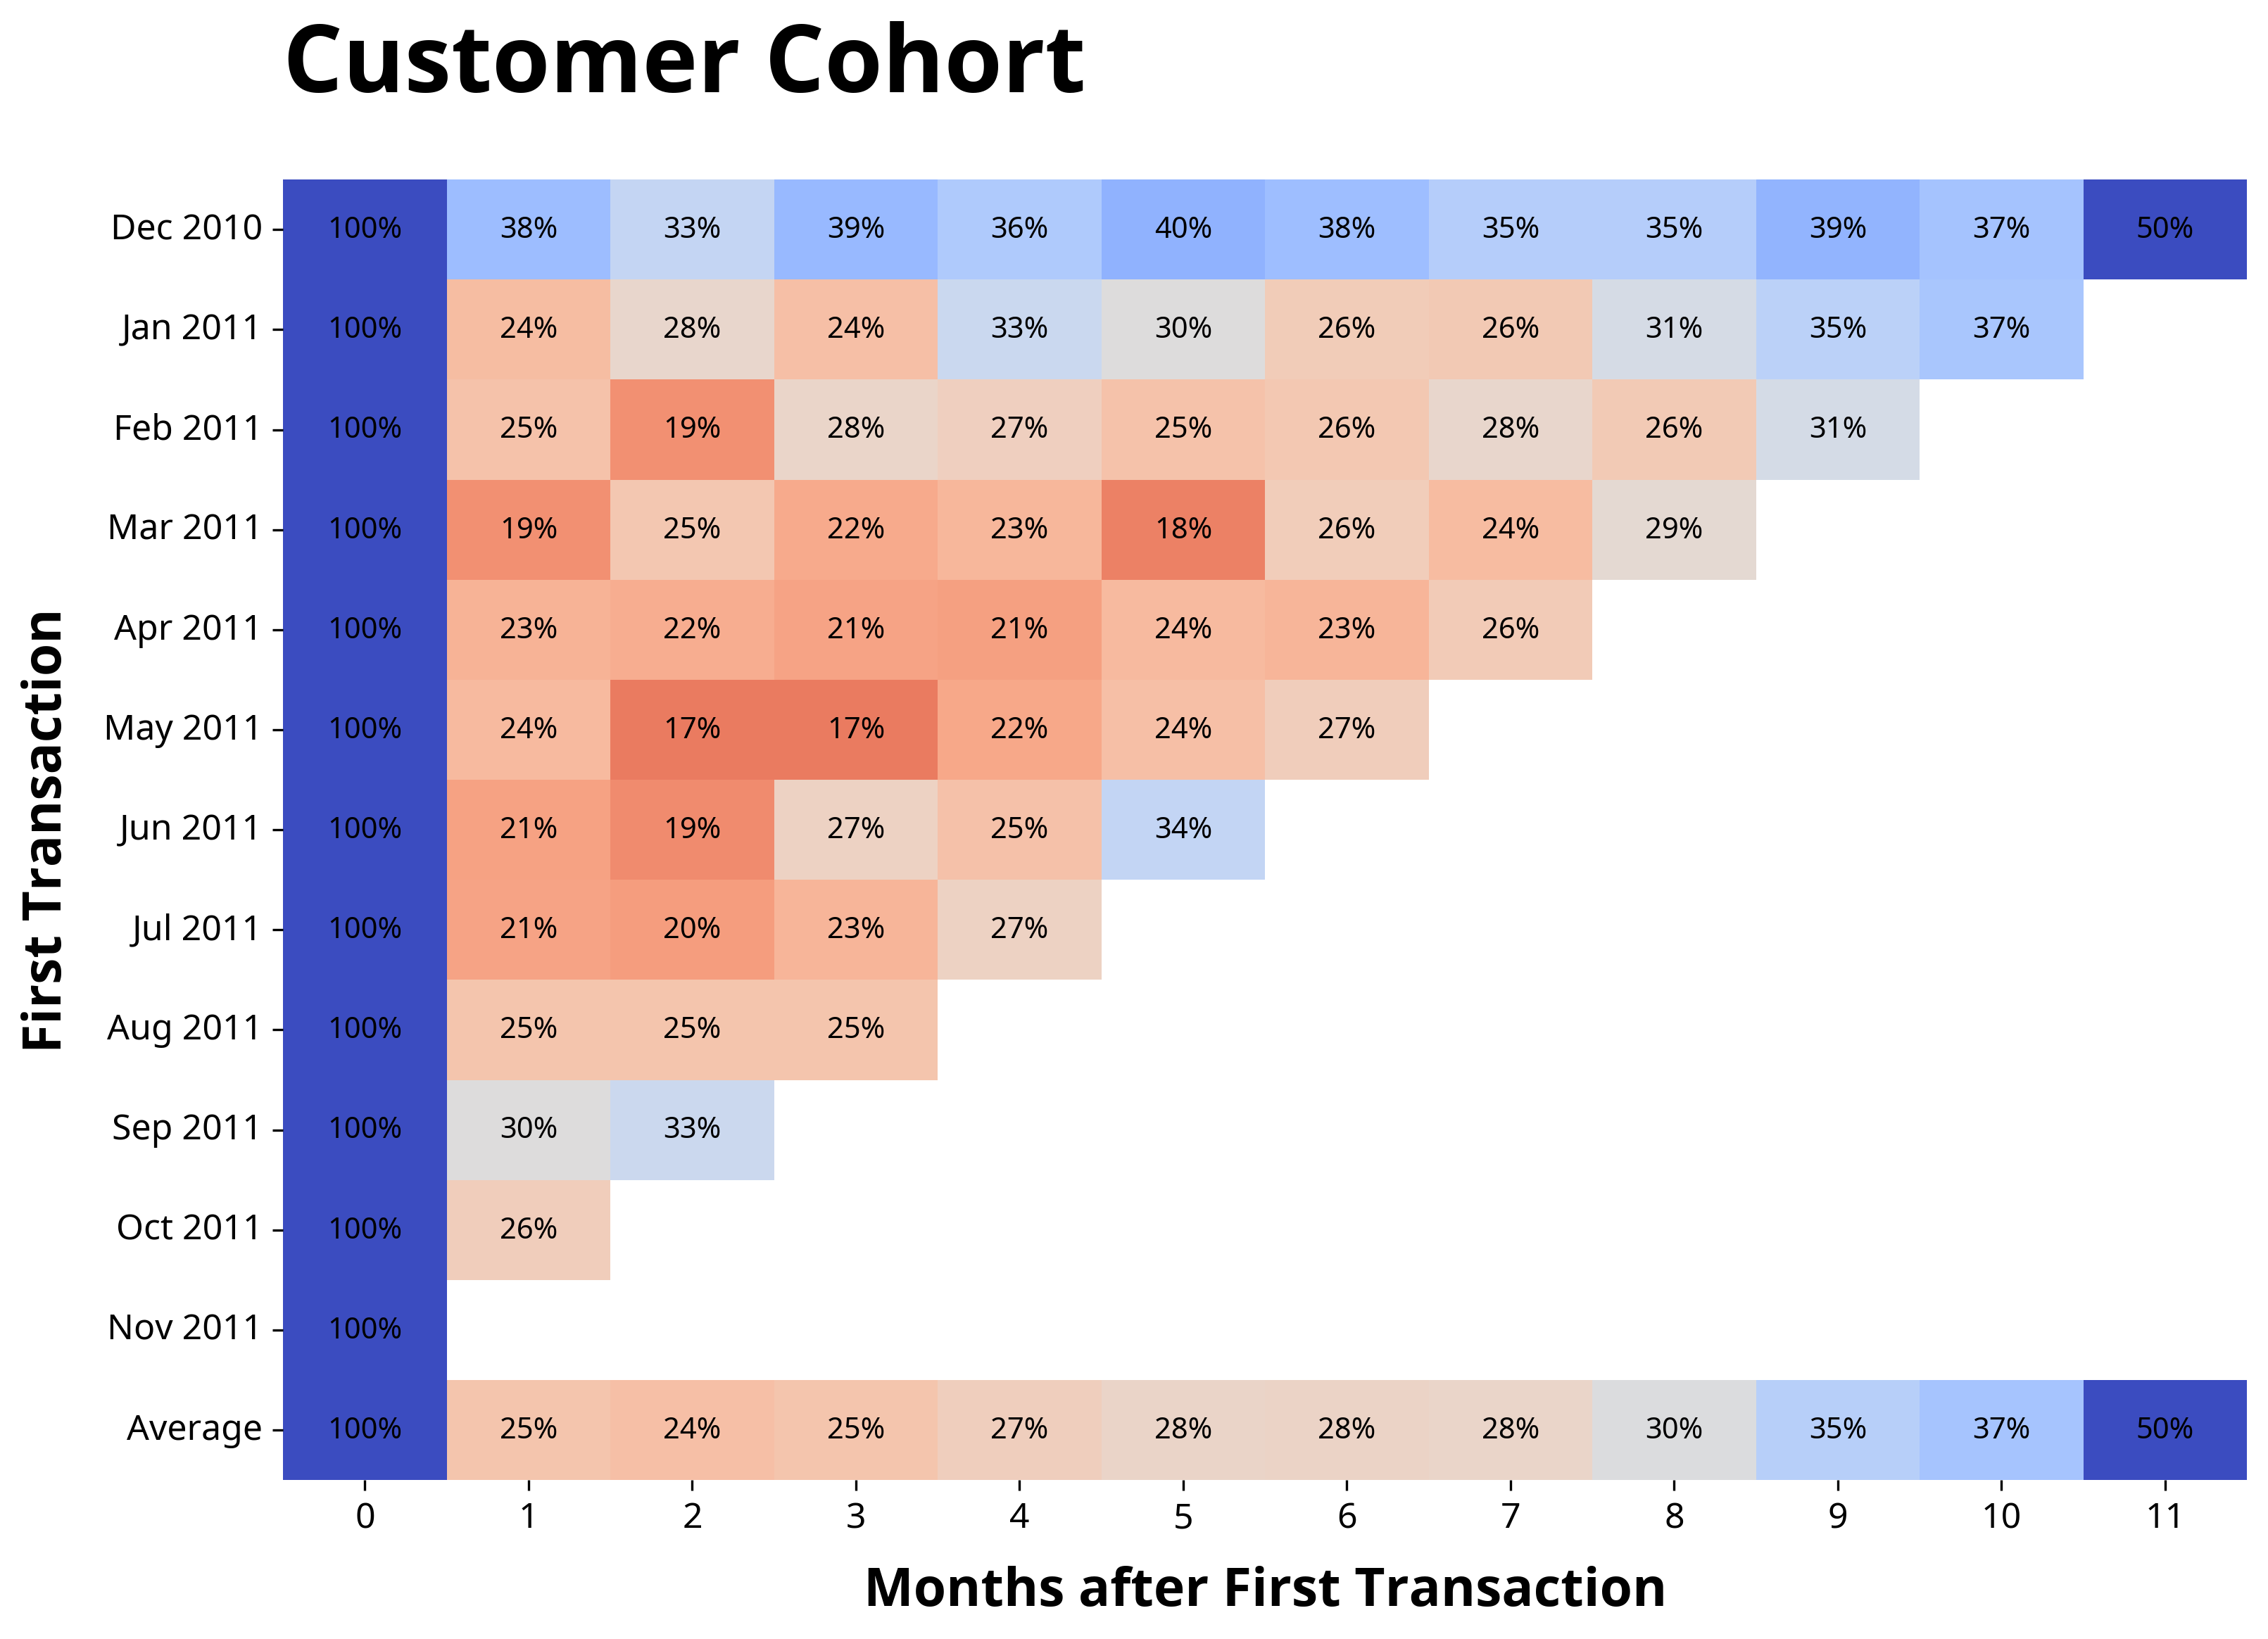

In [66]:
def plot_cohort(df_cohort, cmap="coolwarm_r", vmin=0.1, vmax=0.5):

    plt.figure(figsize=(12, 8), dpi=300)

    sns.heatmap(df_cohort, cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
    # manually annotate because for whatever reason the annotation from sns does not work
    for i in range(df_cohort.shape[0]):
        for j in range(df_cohort.shape[1]):
            if not np.isnan(v := df_cohort.iloc[i, j]):
                plt.text(j + 0.5, i + 0.5, f"{v:.0%}", ha='center', va='center', color='black', fontsize=10)

    plt.title("Customer Cohort", fontsize=32, fontweight="bold", pad=30, loc="left")
    plt.ylabel("First Transaction", fontweight="bold", fontsize=18, labelpad=10)
    plt.xlabel("Months after First Transaction", fontweight="bold", fontsize=18, labelpad=10)
    plt.show()

plot_cohort(df_cohort)